In [2]:
import numpy as np
from numpy import cos, sin, sqrt, arctan2
import matplotlib.pyplot as plt
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
from astropy.cosmology import Planck15
from scipy.special import sph_harm_y
import pint
from pint.models import get_model
import glob, os #glob2
from astropy import units as u
from astropy.coordinates import SkyCoord

from gwbird.pta import pta_dir
from gwbird.skymap import Basis, PolarizationTensors

cosmo = Planck15
H0 =  cosmo.H0.to('1/s').value
h = 0.7
plt.rcParams['figure.dpi'] = 200
REarth = 6.371 * 1e6 #m
c = 3*1e8

# Catalog

Catalog NANOgrav

In [3]:
def get_pulsars(): # https://zenodo.org/records/14773896

    '''
    Function to get the pulsar data from the PINT models

    '''

    pfiles = glob.glob(pta_dir+ '/'+'*.par')
    pfiles = [pf for pf in pfiles if not 'gbt' in pf and not 'ao' in pf]
    pnames = [pf[4:pf.index('_PINT')] for pf in pfiles]

    RA = {}   # Ascensione Retta (Right Ascension)
    DEC = {}  # Declination
    DIST = {} # Distanza (in parsec)

    for pf in pfiles:
        # Carica il modello PINT
        m = get_model(pf)

        # Estrai le coordinate ICRS (RA e DEC)
        c = m.components['AstrometryEcliptic'].coords_as_ICRS()
        RA[m.PSR.value] = c.ra.deg  # Convertito in gradi
        DEC[m.PSR.value] = c.dec.deg

        # Estrai la distanza (basata sulla parallasse, se disponibile)
        if hasattr(m, 'PX') and m.PX.value > 0:  
            DIST[m.PSR.value] = 1000 / m.PX.value  # Converti la parallasse in parsec
        else:
            DIST[m.PSR.value] = None  # Se la parallasse non è disponibile

    # converti da parsec a metri
    for psr in DIST.keys():
        if DIST[psr] is not None:
            DIST[psr] *= 3.086e16

    # converti da rad dec a  theta phi 

    theta_pulsar = np.deg2rad(90.0 - np.array(list(DEC.values())))
    phi_pulsar = np.deg2rad(list(RA.values()))

    # Calcola le coordinate cartesiane

    # Converte i dizionari in array NumPy
    valid_indices = [psr for psr in DIST if DIST[psr] is not None]  # Escludi None
    DIST_array = np.array([DIST[psr] for psr in valid_indices])
    theta_pulsar = np.deg2rad(90.0 - np.array([DEC[psr] for psr in valid_indices]))
    phi_pulsar = np.deg2rad([RA[psr] for psr in valid_indices])

    # Calcola le coordinate cartesiane
    x_pulsar = np.sin(theta_pulsar) * np.cos(phi_pulsar)
    y_pulsar = np.sin(theta_pulsar) * np.sin(phi_pulsar)
    z_pulsar = np.cos(theta_pulsar)
    pulsar_xyz = np.array([x_pulsar, y_pulsar, z_pulsar]).T

    N_pulsar = len(valid_indices)

    return N_pulsar, pulsar_xyz, DIST_array


# Overlap for all the pulsar pairs

In [4]:
def overlap_PTA(f):

    '''

    Compute the overlap reduction function for a set of pulsars

    parameters:
    f: frequency array

    return:
    overlap: overlap reduction function for a set of pulsars

    '''

        
    def F(theta, phi, psi, p): # https://arxiv.org/pdf/1306.5394, https://arxiv.org/abs/2407.14460
        '''
        Compute the antenna pattern functions for a given direction of the source and polarization angle psi
        
        Parameters:
        theta, phi: angles of the source
        psi: polarization angle
        p: unit vector of the pulsar [x, y, z]
        '''
        Omega = Basis.m_n_Omega_basis(theta, phi, psi)[2]
        p = p.reshape(3, 1, 1)
        D = 0.5 * np.einsum('i..., j... -> ij...', p, p)  / (1 + np.einsum('ijk, ijk -> jk', Omega, p))
        e_plus, e_cross, e_x, e_y, e_b, e_l  = PolarizationTensors.e_pol(theta, phi, psi)
        #print('shape e ', e_plus.shape)
        F_plus = np.einsum('ijkl, klij ->kl ', D, e_plus)
        F_cross = np.einsum('ijkl, klij ->kl', D, e_cross) 
        F_x = np.einsum('ijkl, klij ->kl', D, e_x)
        F_y = np.einsum('ijkl, klij ->kl', D, e_y)
        F_b = np.einsum('ijkl, klij ->kl', D, e_b)
        F_l = np.einsum('ijkl, klij ->kl', D, e_l) 
        return F_plus, F_cross, F_x, F_y, F_b, F_l


    def k(L, theta, phi, psi, p, f):
        Omega = Basis.m_n_Omega_basis(theta, phi, psi)[2]
        p = p.reshape(3, 1, 1)
        f = f.reshape(len(f), 1, 1)
        factor =  (1 + np.einsum('ijk, ijk -> jk', Omega, p)) /3e8 
        return   1 - np.exp(- 1j * 2 * np.pi * L* f * factor)

    def gamma_integrand(theta, phi, psi, p1, L1, p2, L2):
        Fp1 = F(theta, phi, psi, p1)
        Fp2 = F(theta, phi, psi, p2)
        gamma_ij = 3/ 2 * (Fp1[0] * Fp2[0] + Fp1[1] * Fp2[1])
        k1 = k(L1, theta, phi, psi, p1, f)
        k2 = k(L2, theta, phi, psi, p2, f)
        return gamma_ij #* k1 * k2

    def gamma(L1, L2, p1, p2, f):
        theta = np.linspace(0, np.pi, 100)
        phi = np.linspace(0, 2*np.pi, 100)
        Theta, Phi = np.meshgrid(theta, phi)
        integrand = gamma_integrand(Theta, Phi, 0, p1, L1, p2, L2)
        integral = np.trapezoid(np.trapezoid(np.sin(Theta) * integrand, theta), phi)
        return np.real(integral)/4* np.pi


    N_pulsar, pulsar_xyz, DIST_array = get_pulsars()
    
    overlap = np.zeros(len(f))

    for i in range(N_pulsar):
        for j in range(i +1, N_pulsar):
            overlap += gamma(DIST_array[i], DIST_array[j], pulsar_xyz[i], pulsar_xyz[j], f)
            
    return overlap

In [5]:
overlap = overlap_PTA(np.linspace(1e-9, 1e-7, 100))

2025-02-26 17:03:54.924 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


In [6]:
print(overlap)

[874.52129049 874.52129049 874.52129049 874.52129049 874.52129049
 874.52129049 874.52129049 874.52129049 874.52129049 874.52129049
 874.52129049 874.52129049 874.52129049 874.52129049 874.52129049
 874.52129049 874.52129049 874.52129049 874.52129049 874.52129049
 874.52129049 874.52129049 874.52129049 874.52129049 874.52129049
 874.52129049 874.52129049 874.52129049 874.52129049 874.52129049
 874.52129049 874.52129049 874.52129049 874.52129049 874.52129049
 874.52129049 874.52129049 874.52129049 874.52129049 874.52129049
 874.52129049 874.52129049 874.52129049 874.52129049 874.52129049
 874.52129049 874.52129049 874.52129049 874.52129049 874.52129049
 874.52129049 874.52129049 874.52129049 874.52129049 874.52129049
 874.52129049 874.52129049 874.52129049 874.52129049 874.52129049
 874.52129049 874.52129049 874.52129049 874.52129049 874.52129049
 874.52129049 874.52129049 874.52129049 874.52129049 874.52129049
 874.52129049 874.52129049 874.52129049 874.52129049 874.52129049
 874.52129

# Sensitivity Curve

In [7]:

def pls_PTA(f, snr, Tobs):

    '''
    Compute the power law sensitivity curve for PTA

    parameters:
    f: frequency array
    snr: signal to noise ratio
    Tobs: observation time in years

    return:
    pls: power law sensitivity curve

    '''

    def PTA_Pn():
        DT = (365*24*3600)/20 # s
        s = 100 * 1e-9 #s
        return 2* (s**2) * DT

    def PTA_Sn(f):
        f = np.asarray(f) # Ensure f is a NumPy array
        mask = f >= 8e-9 # Create a boolean mask where True indicates elements greater than or equal to 8e-9
        return np.where(mask, PTA_Pn() * 12 * (np.pi**2) * f**2, 1) # Apply the mask to the result

    def PTA_Seff(f, overlap):
        return (overlap)**-0.5 * PTA_Sn(f)

    def PTA_Omegaeff(f, S_eff):
        return 10 * np.pi * np.pi * f**3 * S_eff / (3* (H0**2))

    
    def Omega_beta_PTA(f, snr, Tobs, beta, S_eff):
        Tobs = Tobs*365*24*3600
        fref = 1e-8
        integrand = ((f/fref)**(2*beta))/ (PTA_Omegaeff(f, S_eff)**2)
        integral = np.trapezoid(integrand, f)
        return snr / np.sqrt(2*Tobs*integral)


    def Omega_GW_PTA(f,  beta, fref, snr, Tobs, S_eff):
        return Omega_beta_PTA(f, snr, Tobs, beta, S_eff) * ((f/fref)**(beta))

    def all_Omega_GW_PTA(f, snr, Tobs, S_eff):
        beta = np.linspace(-8, 8, 50)
        fref = 1e-8
        Omega = []
        for i in range(len(beta)):
            Omega.append(Omega_GW_PTA(f, beta[i], fref, snr, Tobs, S_eff))     
        return beta, np.array(Omega)
    
    overlap = overlap_PTA(f)
    S_eff = PTA_Seff(f, overlap)
    beta, Omega = all_Omega_GW_PTA(f, snr, Tobs, S_eff)
    pls = np.zeros(len(f))
    for i in range(len(f)):
        pls[i] = np.max(Omega[:,i])
    return pls

In [8]:
f = np.logspace(-9, -7, 100)
Tobs = 20
snr = 1

pls = pls_PTA(f, snr, Tobs)

2025-02-26 17:05:00.044 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


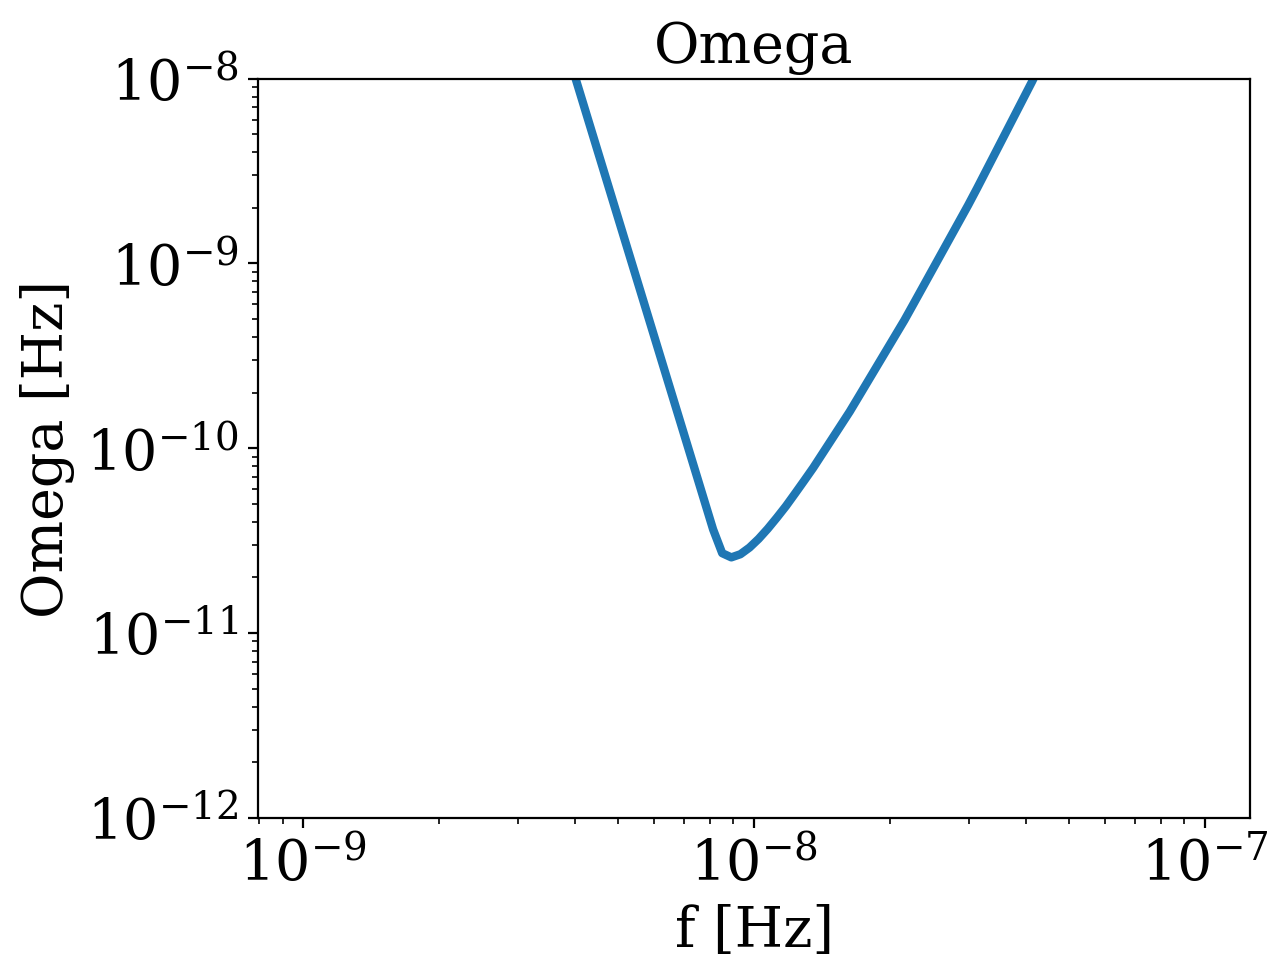

In [9]:
plt.loglog(f, pls)
plt.xlabel('f [Hz]')
plt.ylabel('Omega [Hz]')
plt.title('Omega')
plt.ylim(1e-12, 1e-8)
plt.show()


In [10]:
print(np.min(pls))

2.5665369271426935e-11


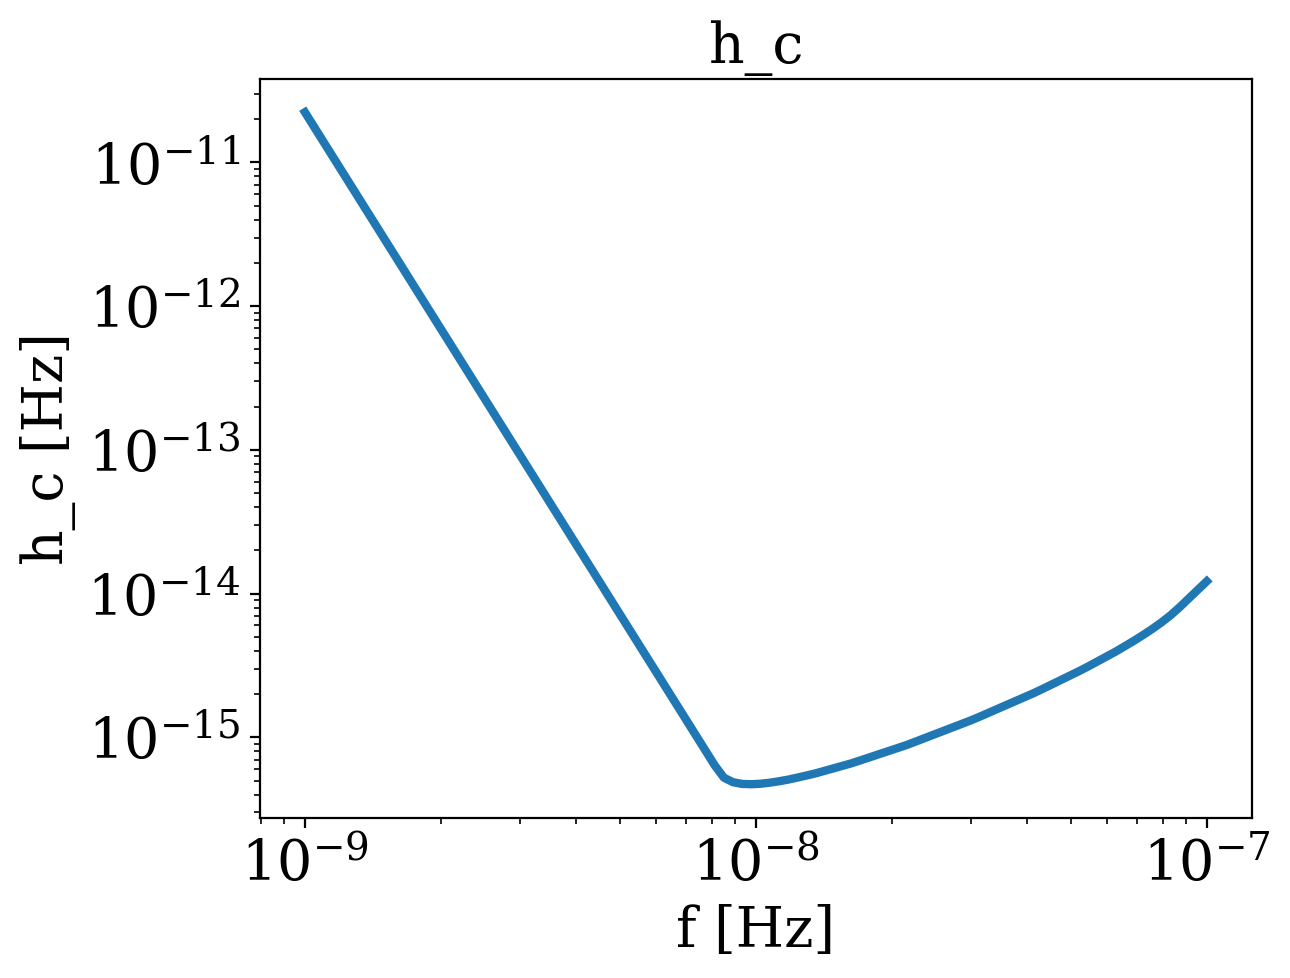

In [11]:
h_c_sens = np.sqrt(3 * H0**2 * pls / (2 * np.pi**2 * f**2))

plt.plot(f, h_c_sens)
plt.xlabel('f [Hz]')
plt.ylabel('h_c [Hz]')
plt.title('h_c')
plt.xscale('log')
plt.yscale('log')

# Angular response

In [12]:
def angular_response_PTA(ell, f):

    '''

    Compute the overlap reduction function for a set of pulsars

    parameters:
    ell: multipole
    f: frequency array

    return:
    angular respone: angular response for a set of pulsars

    '''

        
    def F(theta, phi, psi, p): # https://arxiv.org/pdf/1306.5394, https://arxiv.org/abs/2407.14460
        '''
        Compute the antenna pattern functions for a given direction of the source and polarization angle psi
        
        Parameters:
        theta, phi: angles of the source
        psi: polarization angle
        p: unit vector of the pulsar [x, y, z]
        '''
        Omega = Basis.m_n_Omega_basis(theta, phi, psi)[2]
        p = p.reshape(3, 1, 1)
        D = 0.5 * np.einsum('i..., j... -> ij...', p, p)  / (1 + np.einsum('ijk, ijk -> jk', Omega, p))
        e_plus, e_cross, e_x, e_y, e_b, e_l  = PolarizationTensors.e_pol(theta, phi, psi)
        F_plus = np.einsum('ijkl, klij ->kl ', D, e_plus)
        F_cross = np.einsum('ijkl, klij ->kl', D, e_cross) 
        F_x = np.einsum('ijkl, klij ->kl', D, e_x)
        F_y = np.einsum('ijkl, klij ->kl', D, e_y)
        F_b = np.einsum('ijkl, klij ->kl', D, e_b)
        F_l = np.einsum('ijkl, klij ->kl', D, e_l) 
        return F_plus, F_cross, F_x, F_y, F_b, F_l


    def k(L, theta, phi, psi, p, f):
        Omega = Basis.m_n_Omega_basis(theta, phi, psi)[2]
        p = p.reshape(3, 1, 1)
        f = f.reshape(len(f), 1, 1)
        factor =  (1 + np.einsum('ijk, ijk -> jk', Omega, p)) /3e8 
        return   1 - np.exp(- 1j * 2 * np.pi * L* f * factor)

    def gamma_integrand_ellm(ell, m, theta, phi, psi, p1, L1, p2, L2):
        Fp1 = F(theta, phi, psi, p1)
        Fp2 = F(theta, phi, psi, p2)
        gamma_ij = 3/ 2 * (Fp1[0] * Fp2[0] + Fp1[1] * Fp2[1])
        k1 = k(L1, theta, phi, psi, p1, f)
        k2 = k(L2, theta, phi, psi, p2, f)
        return gamma_ij * k1 * k2 * sph_harm_y(ell, m, theta, phi)* np.sqrt(4* np.pi)/ (4*np.pi)

    def gamma_ellm(ell, m, L1, L2, p1, p2, f):
        theta = np.linspace(0, np.pi, 100)
        phi = np.linspace(0, 2*np.pi, 100)
        Theta, Phi = np.meshgrid(theta, phi)
        integrand = gamma_integrand_ellm(ell, m, Theta, Phi, 0, p1, L1, p2, L2)
        integral = np.trapezoid(np.trapezoid(np.sin(Theta) * integrand, theta), phi)
        return np.real(integral)
    
    def gamma_ell(ell, L1, L2, p1, p2, f):
        gamma_l = 0
        for m in range(-ell, ell+1):
            gamma_l += np.abs(gamma_ellm(ell, m, L1, L2, p1, p2, f))**2
        return np.sqrt(gamma_l)


    N_pulsar, pulsar_xyz, DIST_array = get_pulsars()
    
    angular_response = np.zeros(len(f))

    for i in range(N_pulsar):
        for j in range(i +1, N_pulsar):
            angular_response += gamma_ell(ell, DIST_array[i], DIST_array[j], pulsar_xyz[i], pulsar_xyz[j], f)
            
    return angular_response * np.sqrt(4* np.pi)

In [15]:
f = np.logspace(-9, -7, 100)
R0 = angular_response_PTA(0, f)
R1 = angular_response_PTA(1, f)
R2 = angular_response_PTA(2, f)

2025-02-26 17:11:48.380 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates
2025-02-26 17:13:10.181 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates
2025-02-26 17:17:09.400 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


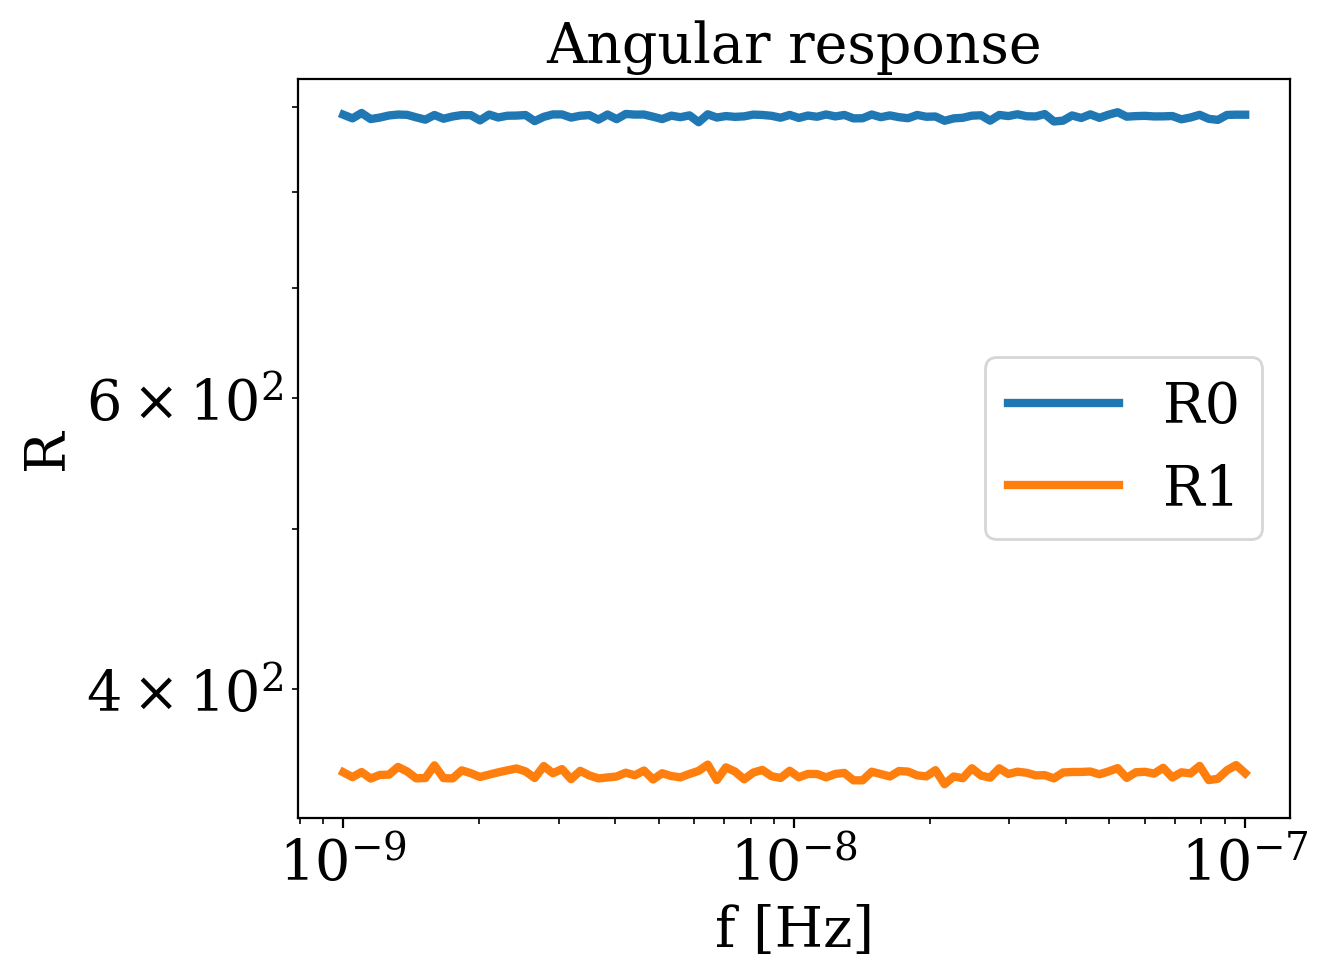

In [16]:
plt.loglog(f, R0, label = 'R0')
plt.loglog(f, R1, label = 'R1')
# plt.loglog(f, R2, label = 'R2')
plt.xlabel('f [Hz]')
plt.ylabel('R')
plt.title('Angular response')
plt.legend()

In [17]:
print(R0/overlap)

[1.01866157 1.01349273 1.02107567 1.01251965 1.01461941 1.01758208
 1.01889239 1.01849142 1.01494154 1.01166027 1.01822759 1.01297135
 1.01618046 1.01813318 1.01796609 1.01062565 1.01887855 1.01474006
 1.01721603 1.01743115 1.01821062 1.00963315 1.01566858 1.01909113
 1.01904949 1.01460752 1.01717991 1.0181036  1.0116955  1.01891341
 1.01238761 1.01970124 1.01882097 1.01891457 1.01582561 1.01248573
 1.01732667 1.01515204 1.01775201 1.0080547  1.01921358 1.01466858
 1.01674428 1.01560996 1.01633953 1.01881116 1.01831544 1.01710725
 1.01442502 1.01837919 1.01411566 1.01749106 1.01574849 1.01904601
 1.01623294 1.01831085 1.01346689 1.01364403 1.01889308 1.01513409
 1.01769795 1.0151565  1.013698   1.01832004 1.01575666 1.01612652
 1.01010576 1.013451   1.01433019 1.01730179 1.01784782 1.01024767
 1.01833338 1.01673249 1.01931677 1.01650501 1.01622403 1.01960114
 1.00912399 1.01023302 1.0176196  1.01403058 1.01916989 1.0142376
 1.01866901 1.02219574 1.01587609 1.01669102 1.01704855 1.01622